# Map-based simulation for differential gain

## Here, we introduce how to assess differential gain systematics by the map-based simulation in the case of a single detector on the boresight.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sbm import Field, ScanFields, SignalFields
import sbm

# Load the cross-link on the boresight detector

## Input map: CMB (r=0), No Gaussian beam smoothing


In [2]:
# Load single detector map
#base_path = "../maps"
scan_field = ScanFields.load_det("boresight/boresight")
fiducial_map = hp.read_map("../maps/cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6

fwhm = np.deg2rad(1.0)
input_map = hp.smoothing(fiducial_map, fwhm)
nside = hp.npix2nside(len(input_map[0]))
lmax = 3*nside-1
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)

# Set a differential gain parameter

`g_a`: a gain of `detector-A` $\to g^A$

`g_b`: a gain of `detector-B`, which constructs orthgonal pair with `detector-A` $\to g^B$

Here, we set `1%` differential gain


In [3]:
g_a = 0.001
g_b = 0.0
delta_g = g_a - g_b
I = input_map[0]
P = input_map[1] + 1j*input_map[2]

signal_field = SignalFields(
    Field(delta_g*I/2, spin_n=0, spin_m=0),
    Field((2.0+g_a+g_b)*P/4, spin_n=2, spin_m=0),
    Field((2.0+g_a+g_b)*P.conj()/4, spin_n=-2, spin_m=0),
)


# Couple the signal field with the scan field


In [30]:
mdim = 2
s_0 = signal_field.get_coupled_field(scan_field, spin_n_out=0, spin_m_out=0)
sp2 = signal_field.get_coupled_field(scan_field, spin_n_out=2, spin_m_out=0)
signal_field.coupled_fields = np.array([sp2/2.0, sp2.conj()/2.0])
signal_field.spin_n_basis = [2,-2]
signal_field.spin_m_basis = [0,0]

# Solve the liner system

Detailed discription coming soon...


In [31]:
output_map = scan_field.map_make(signal_field)
residual = input_map - output_map

# Let's check the Input/Output/Residual maps

Especially, we can see that the residual map (Q and U) which is reconstructed by 2D noise covariant matrix are contaminated by the gain offset.


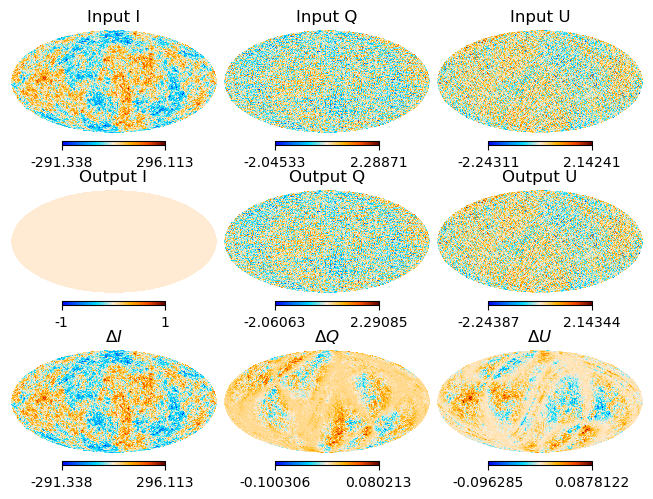

In [32]:
cmap = sbm.get_cmap()
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

In [34]:
r = 0.001
fiducial_cl = sbm.load_fiducial_cl(r)
res_cl = hp.anafast(residual)

# Let's check the power spectra

The green line shows systematics power spectrum, i.e., $\Delta C_\ell^{BB}$, which is obtained by residual map.

We can see it has a similar shape with the input temperature power spectrum, as we expected.

Althogh the green line is providing an exact solution which agrees with the binning map-making, we can perform an analitical estimation without doing the map-making.

The red line $\Delta C_{\ell, Ana}^{BB}$ is simulated by

$$
\Delta C_{\ell, Ana}^{BB} = \frac{1}{2} C_{\ell}^{TT} \langle|{}_{2}\tilde{h}|^2\rangle  \Delta g^2
$$

where $\langle|{}_{2}\tilde{h}|^2\rangle$ represents the entire sky average of the spin-2 cross-link, and $\Delta g=g^A - g^B$.

About the analitical discription, see [C.G.R. Wallis et al.](https://arxiv.org/abs/1604.02290).


'\nplt.savefig("./figures/gain_bore_cl_2x2.pdf")\nplt.figure()\nhp.mollview(residual[1], title="$\\Delta Q$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/gain_bore_dQ_2x2.pdf")\nplt.figure()\nhp.mollview(residual[2], title="$\\Delta U$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/gain_bore_dU_2x2.pdf")\n'

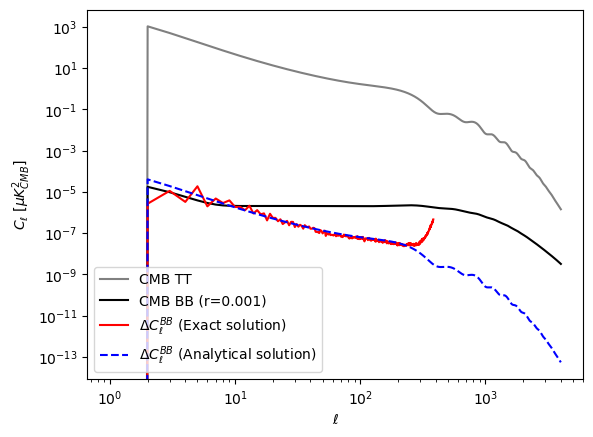

In [8]:
xlink_mean = np.mean(np.abs(scan_field.get_xlink(2,0))**2)
ana = (1/2) * fiducial_cl[0] * xlink_mean * delta_g**2

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution
plt.plot(ana, "--", label="$\Delta C_\ell^{BB}$ (Analytical solution)", color="blue")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();
"""
plt.savefig("./figures/gain_bore_cl_2x2.pdf")
plt.figure()
hp.mollview(residual[1], title="$\Delta Q$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/gain_bore_dQ_2x2.pdf")
plt.figure()
hp.mollview(residual[2], title="$\Delta U$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/gain_bore_dU_2x2.pdf")
"""

# 3x3 matrix reconstruction

So far, map-make has been carried out with a 2x2 matrix from the point of view of differential signal analysis, but we will check what happens to the systematic error by explicitly reconstructing the temperature as well.


In [24]:
mdim = 3
signal_field = SignalFields.diff_gain_field(
    scan_field,
    mdim,
    g_a,
    g_b,
    I,
    P,
)
output_map = scan_field.map_make(signal_field)
residual = input_map - output_map

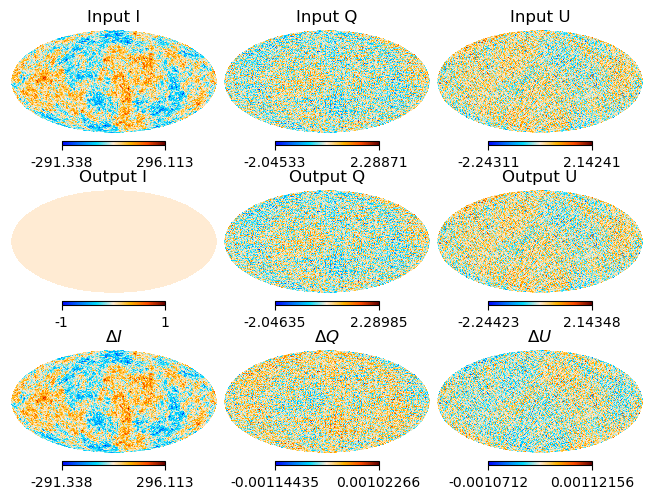

In [25]:
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

It can be seen that the systematic error is smaller thanks to the disappearance of leakage from the temperature.

The transfer function for the $\Delta C_\ell^{BB}$ is give by

$$
\Delta C_{\ell, Ana}^{BB} = \frac{1}{4} C_{\ell}^{BB} \Delta g^2,
$$

it doesn's depend on cross-link any more.


'\nplt.savefig("./figures/gain_bore_cl_3x3.pdf")\nplt.figure()\nhp.mollview(residual[1], title="$\\Delta Q$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/gain_bore_dQ_3x3.pdf")\nplt.figure()\nhp.mollview(residual[2], title="$\\Delta U$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/gain_bore_dU_3x3.pdf")\n'

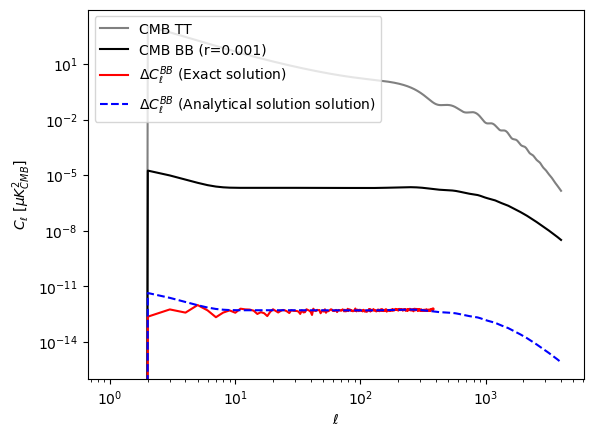

In [11]:
res_cl = hp.anafast(residual)
ana = (1/4) * fiducial_cl[2] * (delta_g)**2
plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution
plt.plot(ana, "--", label="$\Delta C_\ell^{BB}$ (Analytical solution solution)", color="blue")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();
"""
plt.savefig("./figures/gain_bore_cl_3x3.pdf")
plt.figure()
hp.mollview(residual[1], title="$\Delta Q$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/gain_bore_dQ_3x3.pdf")
plt.figure()
hp.mollview(residual[2], title="$\Delta U$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/gain_bore_dU_3x3.pdf")
"""